## Load libraries and files

In [1]:
# Install any of the following packages with pip if you don't
# have them installed already
# Install stmpy package with the command "pip3 install getstmpy"
import stmpy
import stmpy.driftcorr as dfc
import h5py
import scipy as sp
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Pre-define functions to do data recovery

from pylbfgs import owlqn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T
#     print(shape(x2))
#     x2 = x2 * np.hanning(nx)[:, None] * np.hanning(nx)[None, :]
    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx


def dct2(x):
#     x, y = np.shape(x)
#     w = np.hanning(x)[:, None] * np.hanning(x)[None, :]
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
#     return stmpy.tools.ifft(x)
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

## drift correct then reconstruction

In [7]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo001.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)

In [8]:
# Convert a stmpy object to dfc object
# dfc.getAttrs(t)
dfc.getAttrs(t)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

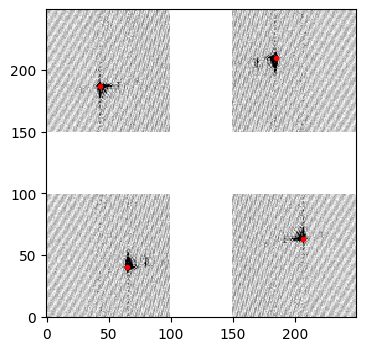

In [9]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


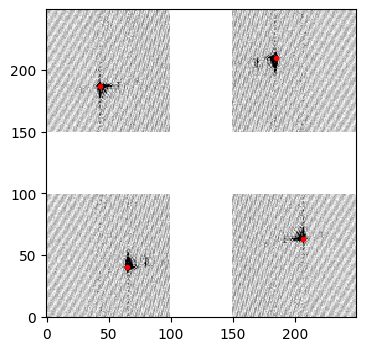

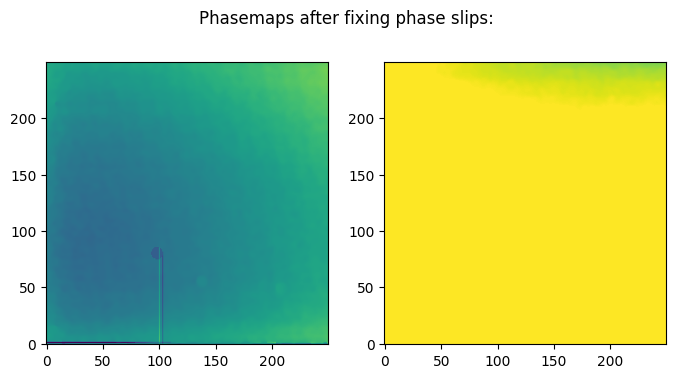

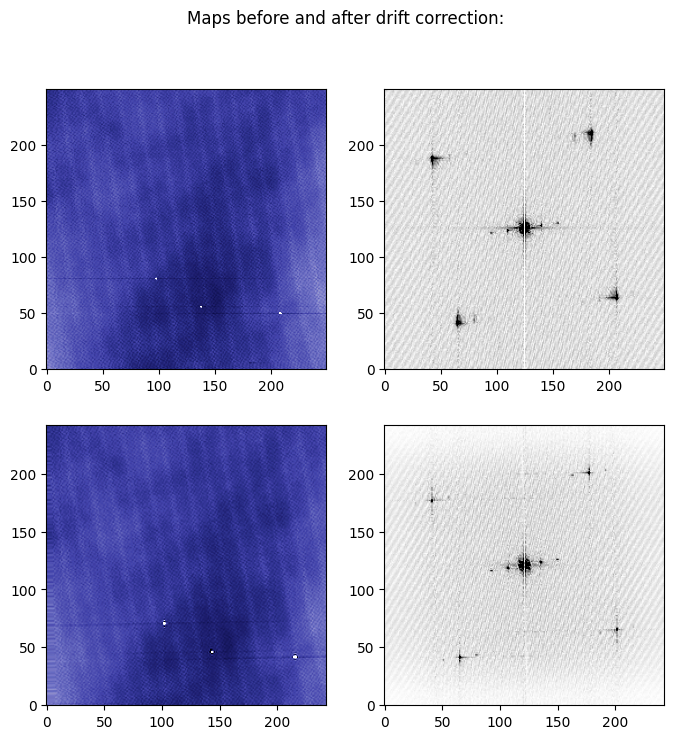

In [20]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, cut2=[0,7,0,7], sigma=20, show=True, method='lockin')

In [21]:

test = t.z_c
nx, ny = shape(t.z_c)

# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

In [22]:
testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * 1e-15

Iteration 1:
  fx = 54649.869842, xnorm = 242.066184, gnorm = 465.435971, step = 0.002139, k = 1, ls = 1

Iteration 2:
  fx = 1567.822544, xnorm = 71.035582, gnorm = 56.152884, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 715.092544, xnorm = 56.175201, gnorm = 14.981739, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 592.667849, xnorm = 48.217678, gnorm = 14.807306, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 42.497410, xnorm = 5.742077, gnorm = 11.803004, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 5.089617, xnorm = 2.489565, gnorm = 3.361193, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 0.894977, xnorm = 0.841772, gnorm = 1.555602, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 0.000000, xnorm = 0.000000, gnorm = 0.000000, step = 1.000000, k = 8, ls = 1



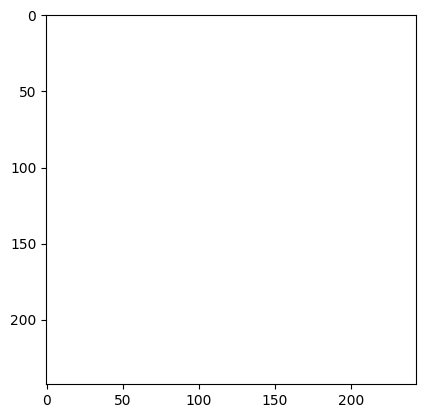

In [23]:
# thre=7e-2
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+0.3*s2])